# LCPB 22-23 Exercise 1 (Gradient descent & Deep Neural Networks, DNNs) 


<center><h1>Group 2307</h1></center>


<center><style>
table {
    font-size: 24px;
}
</style></center>

| Last Name          | First Name            |Matricola number|
|--------------------|-----------------------|----------------|
| Bertinelli         | Gabriele              |1219907 (tri)   |
| Cacciola           | Martina               |2097476         |
| Pervysheva         | Yelyzaveta            |2039398         |           
| Waththe Liyanage   | Wageesha Widuranga    |2078719         |




## Overview

In this assignment, we will analyze labeled 2D data x=(x1,x2) introduced in the second lesson using Deep Neural Networks (DNNs) and gradient descent. The main goals of the assignment are:

1. Implement a "grid search" to improve at least two aspects or hyperparameters of the model.
2. Take the best DNN from point 1 and study how its performance changes when the number N of samples is a) reduced, b) increased, or c) augmented.
3. Optionally, we will explore what happens with data generated by the second nonlinear function or other choices.

### Implementation Details

#### Grid Search
To improve the DNN model, we will implement a "grid search" technique, as shown in the Mehta et al. notebook NB11, where we will explore different hyperparameters of the model. We will focus on at least two aspects, such as the choice of the minimization algorithm (ADAM, RMSprop, Nesterov, etc.), activation units (sigmoid, ReLU, ELU, etc.), dropout values, learning rate, size or number of layers, and rescaling of data.

#### Performance Analysis
After improving the DNN model, we will analyze how its performance changes with different sample sizes, including reduced, increased, and augmented datasets. For the augmented dataset, we will generate artificial training samples similar to the real ones, where each sample x=($x_1$, $x_2$) is transformed to multiple copies ($x_1+s_1$, $x_2+s_2$), where each ($s_1$, $s_2$) is a reasonably slight random shift. We will also explain our choice for the variability of this shift and why we do not augment the validation samples.

#### Optional Exploration
Optionally, we will explore what happens with data generated by the second nonlinear function or other choices.


# Importing some packages and modules

In [45]:
from __future__ import print_function
import keras, sklearn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed=0
np.random.seed(seed)

In [46]:
# from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam
from keras.optimizers import adam_v2, rmsprop_v2, nadam_v2, adamax_v2
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier

# Load Dataset

The dataset is generated by randomly generating 4000 data points with coordinates following a uniform distribution in the range of -50 to +50. The points are labeled with a value of `1` if they satisfy all three boundary conditions, `0` otherwise.

In [54]:
x = np.loadtxt('../Exercises/E1/DATA/data-for-DNN-1.dat')
y = np.loadtxt('../Exercises/E1/DATA/labels-for-DNN-1.dat')

# Plot Dataset

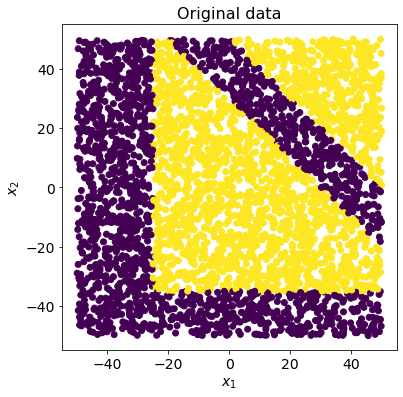

In [55]:
plt.figure(figsize = (6, 6))
plt.scatter(x[:,0], x[:,1], c=y, marker='o')
plt.title('Original data', fontsize=16)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

# Define size of the training set

In this code we define the proportion of the original dataset to be used as training data using the variable `Per_train` (here set to 0.8, i.e., 80% of the data), and we calculate the number of samples in the original dataset using N and the number of features (dimensionality) of each sample using L.

In [56]:
Per_train = 0.8

N = len(x)
L = len(x[0])
N_train = int(Per_train*N)

print("Number of samples in the dataset:", N)
print("Number of samples in the train data:", N_train)

Number of samples in the dataset: 4000
Number of samples in the train data: 3200


# Spliting Training and Validation data

We split the data betweet training and validation set, based on the `Per_train` value.  
We shuffle the two new dataset in anticipation of forming mini-batches. This is an important step in order to prevent that the gradient method can fit spurious correlations resulting from the order in which data is presented.

In [57]:
(x_train, y_train) = (x[0:N_train], y[0:N_train])
(x_valid, y_valid) = (x[N_train:], y[N_train:])

print("Train samples:",len(x_train),"\t Validation samples:",len(x_valid))

Train samples: 3200 	 Validation samples: 800


# Rescaling

It has been found that if the original values of data differ by order of magnitude, training can be slowed down or impeded. This can be traced back to the _vanishing and exploding gradient problem_.  

To avoid this all data should be mean-centered (i.e. `x-x.mean()`) and should be rescaled. In our case the data are normally distributed so we rescale them by the standard deviation (`x.std()`). Rescaling ensures that the weights of the DNN are of a similar order of magnitude.  

This two passages are included in the function `Rescaling(x)`. We apply it to the training x=($x_1$, $x_2$) values. 
The labels don't need to be "adjusted" because they are simply 0 or 1.

In [58]:
def Rescaling(x):
    X = (x-x.mean())/x.std()
    return X

x_train = Rescaling(x_train)
x_valid = Rescaling(x_valid)

print("Training samples:", len(x_train))

Training samples: 3200


# Following cases

The steps desribed above will be repeated for all the following cases:

- original dataset
- reduced dataset
- increased datatset
- augmented dataset

# Model Creation

Here we create the NN model, looking for the best parameters. We focused on:

1. _optimizer_: the optimization algorithm used to train the model, with a default value of Adam optimizer.
2. _activation_: the activation function used for the hidden layers of the network, with a default value of ReLU.
3. _dropout_rate_: the rate at which randomly dropout connections between neurons during training, with a default value of 0.2.

The model consists of an input layer, two hidden layers with 20 neurons each and the specified activation function, a dropout layer to prevent overfitting and an output layer with a sigmoid activation function for binary classification.

The model is compiled using binary cross-entropy loss and accuracy as the evaluation metric. Finally, the model is returned.

In [8]:
def created_model(optimizer= adam_v2.Adam(), activation='relu', dropout_rate=0.2):
    
    model = Sequential() 
    model.add(Dense(L, input_shape=(L,), activation=activation))
    model.add(Dense(20, activation=activation))  
    model.add(Dense(20, activation=activation))
    model.add(Dropout(dropout_rate)) 
    model.add(Dense(1, activation='sigmoid'))
    
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

# Best Optimizer

Here we use _grid search cross-validation_ to find the best optimizer algorithm to use for our NN model. 
We create a `KerasClassifier` object with the `created_model` function we defined earlier, and set the number of epochs to 60 and the batch size to 64. We then define a parameter grid to search over, which includes different optimizer algorithms.


In summary, we use grid search cross-validation to find the best optimizer algorithm to use for our NN model, and store the best optimizer found.

The best optimizer is printed with its mean test score and the std deviation between (). The optimizer tested can be found in the `optimizer` list below.

In [9]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR) # this goes *before* tf import

import tensorflow as tf
tf.autograph.set_verbosity(0)

batch_size = 64

model_gridsearch = KerasClassifier(build_fn=created_model, 
                        epochs=60, 
                        batch_size=batch_size, 
                        verbose=False)

optimizer = ['SGD', 'RMSprop', 'Adagrad','Adam', 'Adamax', 'Nadam']

# define parameter dictionary
param_grid = dict(optimizer=optimizer)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train, y_train)

# summarize results
# print the best optimizer
print("Best: %f using %s\n" % (grid_result.best_score_, grid_result.best_params_))

# print mean test score, std deviation in () and the name of the optimizer
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# store the best optimizer    
best_optimizer = grid_result.best_params_['optimizer']

Best: 0.865937 using {'optimizer': 'Nadam'}

0.741563 (0.053124) with: {'optimizer': 'SGD'}
0.821250 (0.033958) with: {'optimizer': 'RMSprop'}
0.642812 (0.084351) with: {'optimizer': 'Adagrad'}
0.838750 (0.049474) with: {'optimizer': 'Adam'}
0.783437 (0.029809) with: {'optimizer': 'Adamax'}
0.865937 (0.014641) with: {'optimizer': 'Nadam'}


# Best Batch Size

Here, we are tuning the hyperparameter _batch size_ for the NN model. We create a `KerasClassifier` object with the `created_model` function, and set the number of epochs and verbose parameters. 
We then define a range of batch sizes to test and create a grid search object using `GridSearchCV` from `scikit-learn`. 
We fit the grid search object to our training data and print out the best mean test score and corresponding hyperparameters. We also print out the mean test score, standard deviation, and hyperparameters for each batch size tested. 
Finally, we extract the best batch size found by the grid search.

<!--- The result shows that the best mean test score of 0.802187 was achieved with a batch size of 64. The other batch sizes tested, in descending order of mean test score, were 32 and 128. The standard deviation of the test scores is also provided for each batch size. -->

Batch size is an important hyperparameter in NN training. A larger batch size may result in a faster convergence and better optimization, but may also require more memory and slower training time. In contrast, a smaller batch size may require less memory and have faster training time, but may result in a slower convergence and suboptimal optimization.

<!--- The best batch size depends on the epochs value. if it's 50, the best batch is 64. if it's 60, the best is 32`  
`# I think the best way is to be consistent w/ the epochs value of the very first NN, aka epochs=60` -->

In [10]:
model_gridsearch = KerasClassifier(build_fn=created_model, 
                        epochs=50, 
                        batch_size=batch_size, 
                        verbose=False)


batch_size = [32, 64, 128]


param_grid = dict(batch_size=batch_size)

grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s\n" % (grid_result.best_score_, grid_result.best_params_))

# print mean test score, std deviation in () and the size of the batch
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# store the best batch    
best_batch_size = grid_result.best_params_['batch_size']

Best: 0.861875 using {'batch_size': 128}

0.855000 (0.029275) with: {'batch_size': 32}
0.854375 (0.052808) with: {'batch_size': 64}
0.861875 (0.001875) with: {'batch_size': 128}


# Best Droupout Value

The best _dropout rate_ is then selected based on the mean test score.

The model is created with the previously optimized batch size, and an epoch of 50. The dropout rate is set to a list of four values: 0.1, 0.2, 0.3, and 0.4. We use GridSearchCV to perform a 4-fold cross-validation on each of the dropout rates in the list, and the best dropout rate is returned.

<!--- `# I think we should use epochs=60` -->

The results show the mean test score and standard deviation of the test scores for each dropout rate. The best dropout rate found by the grid search is printed along with its corresponding mean test score.

In [11]:
batch_size = best_batch_size

model_gridsearch = KerasClassifier(build_fn=created_model, 
                        epochs=50, 
                        batch_size=batch_size, 
                        verbose=False)


dropout_rate = [0.1, 0.2, 0.3, 0.4]

param_grid = dict(dropout_rate=dropout_rate)


grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# print mean test score, std deviation in () and the dropout rate
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# store the best dropout rate
best_dropout_rate = grid_result.best_params_['dropout_rate']

Best: 0.868125 using {'dropout_rate': 0.3}
0.847812 (0.038460) with: {'dropout_rate': 0.1}
0.817187 (0.034008) with: {'dropout_rate': 0.2}
0.868125 (0.015750) with: {'dropout_rate': 0.3}
0.830625 (0.044146) with: {'dropout_rate': 0.4}


# Best Activation Function

_Activation functions_ are mathematical equations that determine the output of a neural network model. Different activation functions have different effects on the performance and convergence of the model.

The results shown indicate that `ReLU` is the best activation function for our model, as it has the highest mean accuracy and a relatively low standard deviation. This means that `ReLU` is able to produce consistent and accurate outputs for our data.

Some possible reasons why `ReLU` is better than other activation functions are:

- ReLU is simple and computationally efficient.
- ReLU avoids the _vanishing gradient problem_ that affects sigmoid and tanh.
- ReLU can handle sparse data better than linear or softmax.

In [12]:
batch_size = 64
model_gridsearch = KerasClassifier(build_fn=created_model, 
                        epochs=50, 
                        batch_size=batch_size, 
                        verbose=False)


activation = ['softmax', 'softsign', 'relu', 'tanh', 'sigmoid', 'linear']

param_grid = dict(activation=activation)

grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=2, cv=4)
grid_result = grid.fit(x_train, y_train)

#summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# print mean test score, std deviation in () and the name of the activation function
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# store the best activation function
best_activation = grid_result.best_params_['activation']

Best: 0.870937 using {'activation': 'relu'}
0.760937 (0.008855) with: {'activation': 'softmax'}
0.858125 (0.015774) with: {'activation': 'softsign'}
0.870937 (0.017329) with: {'activation': 'relu'}
0.803125 (0.041557) with: {'activation': 'tanh'}
0.757812 (0.021603) with: {'activation': 'sigmoid'}
0.674688 (0.015622) with: {'activation': 'linear'}


# Model with best Parameters

Our best model has the following structure:

- An input layer with L nodes, where L is the dimension of our input data. This layer uses an activation function that we have chosen as the best one for our problem (`best_activation`).
- Two hidden layers with 20 nodes each, using the same activation function as the input layer (`best_activation`).
- A dropout layer with a dropout rate that we have chosen as the best one for our problem (`best_dropout_rate`). This layer randomly drops out some nodes during training to prevent overfitting.
- An output layer with one node, using a `sigmoid` activation function. This layer produces a binary output (0 or 1) for our classification problem.
- A loss function of `binary crossentropy`, which measures how well the model predicts the true labels of our data.
- An optimizer that we have chosen as the best one for our problem (`best_optimizer`), which updates the weights of our model based on the gradients of the loss function.
- A metric of `accuracy`, which measures how many predictions our model gets right on the data.

We now train our best NN model on `x_train` and `y_train` data for 450 epochs, using a batch size that we have chosen as the best one for your problem (`best_batch_size`). We have also validate our model on `x_valid` and `y_valid` data during training to monitor its performance.

This model will be used in all the four cases, changing only the training and validation samples, according to the case (original dataset, reduced dataset, ...)

In [13]:
# Creating and training the NN model w/ our best parameters
epochs = 450

best_model = Sequential() 

activation = best_activation
best_model.add(Dense(L, input_shape=(L,), activation=activation))
best_model.add(Dense(20, activation=activation))  
best_model.add(Dense(20, activation=activation))

dropout_rate = best_dropout_rate
best_model.add(Dropout(dropout_rate))
best_model.add(Dense(1, activation='sigmoid'))

optimizer = best_optimizer

best_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

batch_size = best_batch_size


# Fitting again with more data
fit = best_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_valid, y_valid), verbose=False)

The best valadation accuracy is 0.985


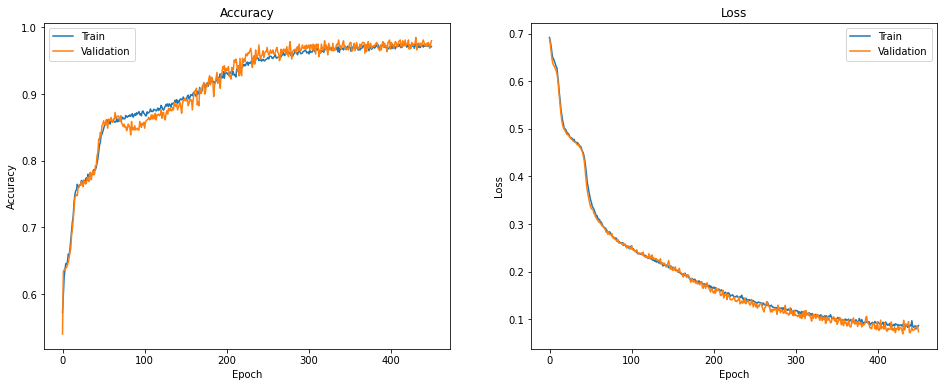

In [14]:
# Printing the max validation accuracy value
max_val_acc = np.max(fit.history['val_accuracy'])
print('The best valadation accuracy is %.3f' %(max_val_acc))

# Creating the plot
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Accuracy in training and validation
ax1.plot(fit.history['accuracy'])
ax1.plot(fit.history['val_accuracy'])

# Setting labels and legend
ax1.set_title('Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'])

# Loss in training and validation
ax2.plot(fit.history['loss'])
ax2.plot(fit.history['val_loss'])

# Setting labels and legend
ax2.set_title('Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'])

plt.show()

The best valadation accuracy, 0.941, was achieved on the 432th epoch.


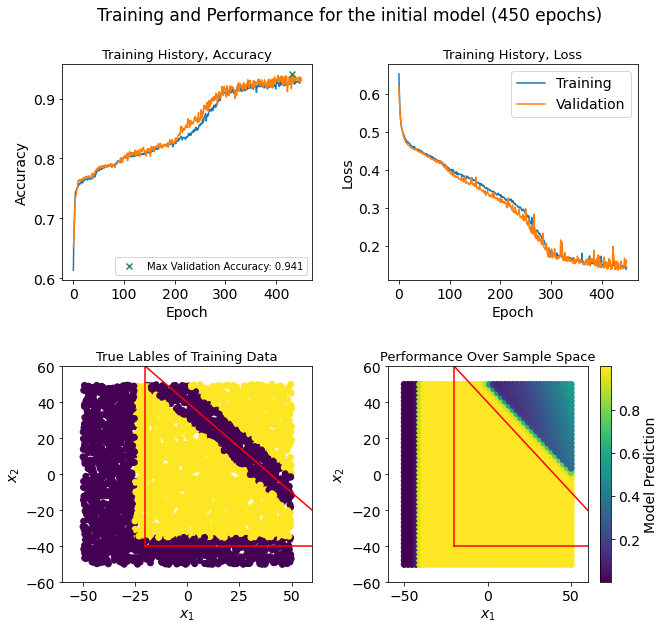

In [52]:
# Defining a grid to represent the sample space
dX = 2 #number of dimensions of the data
LG = int(np.sqrt(4000/2))
x1 = np.linspace(-50, 50, LG)
x2 = np.linspace(-50, 50, LG)
grid = np.zeros((LG*LG, 2))
k = 0
for i in range(LG):
    for j in range(LG):
        grid[k,:]  =(x1[j], x2[i])
        k = k+1

# Rescaling grid points
grid_r = grid/50

# Performing a prediction on grid points
pred = best_model.predict(grid_r)

# Best validation accuracy
plt.rcParams['font.size'] = 14
max_val_acc = np.max(fit.history['val_accuracy'])
max_val_epoch = np.argmax(fit.history['val_accuracy'])
print('The best valadation accuracy, %.3f, was achieved on the %uth epoch.' %(max_val_acc, max_val_epoch))

# perfomance vs epochs plot
fig, AX = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle('Training and Performance for the initial model (450 epochs)', y=1, fontsize=17)

# Training History, Accuracy
ax = AX[0][0]
ax.set_title('Training History, Accuracy', fontsize=13)
mystring = "Max Validation Accuracy: "+str(round(max_val_acc, 3))
ax.scatter(max_val_epoch, max_val_acc, color='seagreen', marker='x', label=mystring, zorder=10)
ax.plot(fit.history['accuracy'])
ax.plot(fit.history['val_accuracy'])
ax.legend(fontsize=10, loc='best')
ax.set_xlabel('Epoch')
ax.set_ylabel("Accuracy")

# Training History, Loss
ax = AX[0][1]
ax.set_title('Training History, Loss', fontsize=13)
ax.plot(fit.history['loss'], label="Training")
ax.plot(fit.history['val_loss'], label="Validation")
ax.set_xlabel('Epoch')
ax.set_ylabel("Loss")
ax.legend()

def boundaries():    
    ax.plot((-20, -20), (-40, 60), c="r")
    ax.plot((-20, 80), (-40, -40), c="r")
    ax.plot((-20, 80), (60, -40), c="r")

# True Lables of Training Data
ax = AX[1][0]
ax.scatter(x[:,0], x[:,1], c=y)
ax.set_title('True Lables of Training Data', fontsize=13)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

boundaries()

# Performance Over Sample Space
ax = AX[1][1]
col = ax.scatter(grid[:,0], grid[:,1], c=pred)
ax.set_title('Performance Over Sample Space', fontsize=13)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.colorbar(col, label='Model Prediction')

boundaries()

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=0.90, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()

The accuracy our NN model achieved means that, out of all the instances or observations in a dataset, the model is correctly predicting the outcome or class label.

## Confusion matrix

The **confusion matrix** is a performance measurement for machine learning classification problem where output can be two or more classes. It is a table with 4 different combinations of predicted and actual values. It is extremely useful for measuring Accuracy, Precision, etc.

This is an example of a confusion matrix:
![This is an example of a confusion matrix.](./confusion_matrix.png)

- True Positive (TP): the model predicted label "positive (1)" and it's the correct one;
- True Negative (TN): the model predicted label "negative (0)" and it's the correct one;
- False Positive (FP): the model predicted label "positive (1)" and it's the not correct one;
- False Negative (FN): the model predicted label "negative (0)" and it's the not correct one;

In term of accuracy the confusion matrix tells us how many labels were predicted correctly (i.e. TP+TN).

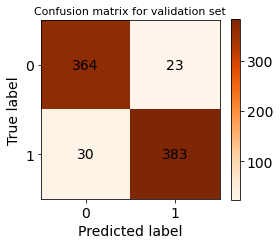

In [53]:
# Predicting the labels for the validation set
y_pred = best_model.predict(x_valid)
y_pred = (y_pred > 0.5).astype(int)

# Computing the confusion matrix
cm = sklearn.metrics.confusion_matrix(y_valid, y_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
plt.title('Confusion matrix for validation set', fontsize=11)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.imshow(cm, cmap='Oranges', interpolation='nearest')
plt.colorbar(shrink=0.83)
plt.xticks([0,1], ['0', '1'])
plt.yticks([0,1], ['0', '1'])

# Adding the number of predictions to each cell
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(cm[i,j]), ha='center', va='center', color='black')

plt.show()

# Reduced data

This code  does the following:

- It loads previous files
- It randomly samples 50% of the rows from `x` and `y` using numpy’s `random.choice` function. This function takes an array of indices, a size of the sample and a boolean flag to indicate whether sampling is done with or without replacement. In this case, sampling is done without replacement, meaning that each row can only be selected once.
- It stores the sampled data and labels in `x_sampled` and `y_sampled` variables.

The reason for doing this is to reduce the size of the dataset for faster training or testing of the DNN model.

In [108]:
# Load the original dataset
x = np.loadtxt('../Exercises/E1/DATA/data-for-DNN-1.dat')
y = np.loadtxt('../Exercises/E1/DATA/labels-for-DNN-1.dat')

# Randomly sample 50% of the rows
n_samples = int(0.5 * len(x))
indices = np.random.choice(len(x), size=n_samples, replace=False)
x_sampled = x[indices]
y_sampled = y[indices]

In [120]:
Per_train = 0.8

N = len(x_sampled)
L = len(x_sampled[0])
N_train = int(Per_train*N)

print("Number of samples in the reduced dataset:",N)
print("Number of samples in the reduced train dataset:",N_train)

# sampling between training and validation samples
(x_train_red, y_train_red) = (x_sampled[0:N_train], y_sampled[0:N_train])
(x_valid_red, y_valid_red) = (x_sampled[N_train:], y_sampled[N_train:])

Number of samples in the reduced dataset: 2000
Number of samples in the reduced train dataset: 1600


In [122]:
# Rescaling the dataset

def Rescaling(x):
    X = (x-x.mean())/x.std()
    return X

x_train_red = Rescaling(x_train_red)
x_valid_red = Rescaling(x_valid_red)

print("Number of samples in the reduced set:", len(x_train_red))

Number of samples in the reduced set: 1600
400


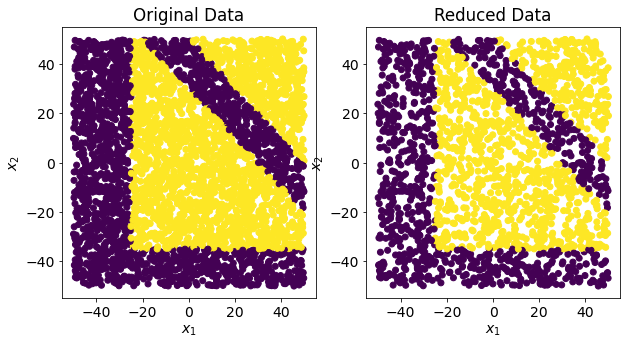

In [123]:
# Plot the original data and the reduced data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(x[:, 0], x[:, 1], c=y)
axs[0].set_title('Original Data')
axs[1].scatter(x_sampled[:, 0], x_sampled[:, 1], c=y_sampled)
axs[1].set_title('Reduced Data')

axs[0].set_xlabel('$x_1$')
axs[0].set_ylabel('$x_2$')
axs[1].set_xlabel('$x_1$')
axs[1].set_ylabel('$x_2$')

plt.show()

In [124]:
# Creating and training our NN model w/ the reduced dataset
epochs = 450

best_model = Sequential() 

activation = best_activation
best_model.add(Dense(L, input_shape=(L,), activation=activation))
best_model.add(Dense(20, activation=activation))  
best_model.add(Dense(20, activation=activation))

dropout_rate = best_dropout_rate
best_model.add(Dropout(dropout_rate))
best_model.add(Dense(1, activation='sigmoid'))

optimizer = best_optimizer

best_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

batch_size = best_batch_size

# Fitting with reduced data
fit_red = best_model.fit(x_train_red, y_train_red, epochs=epochs, batch_size=batch_size, validation_data=(x_valid_red, y_valid_red), verbose=False)

The best valadation accuracy is 0.863.
The accuracy difference between original and reduced datasets is 0.123.


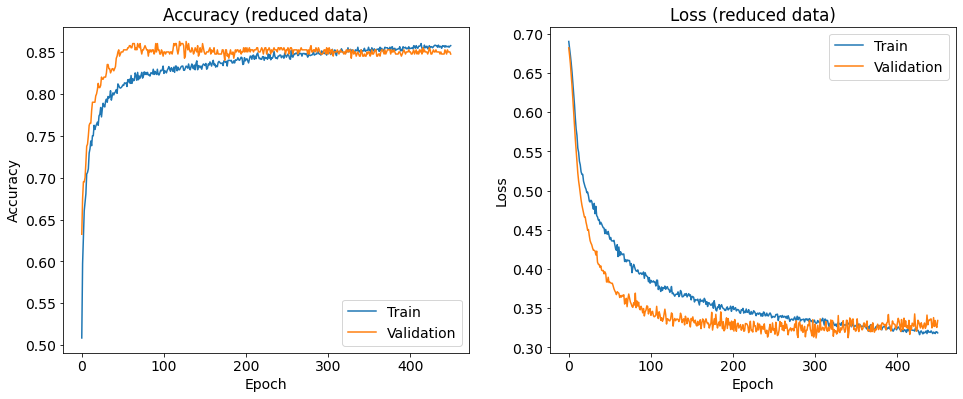

In [125]:
# Printing the max validation accurancy of the reduced dataset and
# the difference w/ the one of original dataset
max_val_acc_red = np.max(fit_red.history['val_accuracy'])
print('The best valadation accuracy is %.3f.' %(max_val_acc_red))
print('The accuracy difference between original and reduced datasets is %.3f.' %((max_val_acc-max_val_acc_red)))

# Creating the plot
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Accuracy in training and validation
ax1.plot(fit_red.history['accuracy'])
ax1.plot(fit_red.history['val_accuracy'])

# Setting labels and legend
ax1.set_title('Accuracy (reduced data)')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'])

# Loss in training and validation
ax2.plot(fit_red.history['loss'])
ax2.plot(fit_red.history['val_loss'])

# Setting laels and legend
ax2.set_title('Loss (reduced data)')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'])

plt.show()

Even if we reduced half of the samples, the accuracy is slightly different from the one wrt the original dataset.

This means that the sampled data still contains enough information to train and test the DNN model with a relatively high accuracy. It also suggests that the original data may have some redundancy or noise that can be removed without affecting the model performance significantly. Reducing the number of samples can have some benefits such as saving memory and computation time, but it can also introduce some risks such as losing important features or introducing bias. 

The best valadation accuracy, 0.863, was achieved on the 119th epoch.


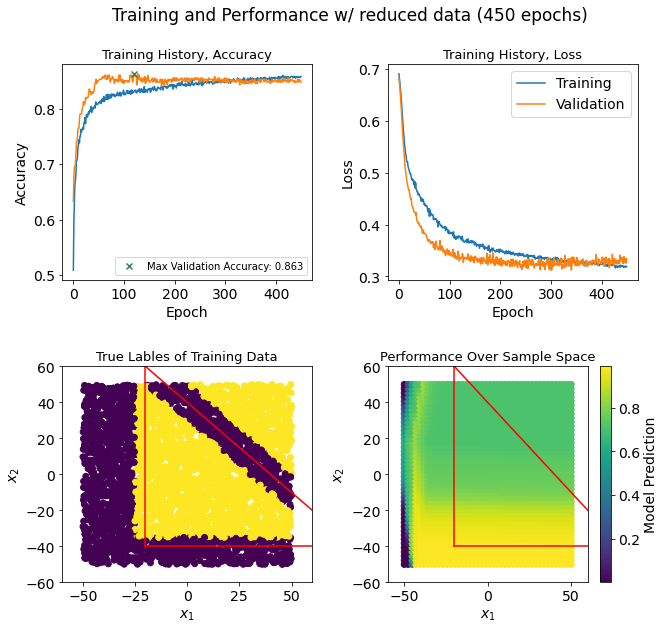

In [126]:
# Defining a grid to represent the sample space
dX = 2 #number of dimensions of the data
LG = int(np.sqrt(4000/2))
x1 = np.linspace(-50, 50, LG)
x2 = np.linspace(-50, 50, LG)
grid = np.zeros((LG*LG, 2))
k = 0
for i in range(LG):
    for j in range(LG):
        grid[k,:] = (x1[j], x2[i])
        k = k+1

# Rescaling grid points
grid_r = grid/50

# Performing a prediction on grid points
pred = best_model.predict(grid_r)


plt.rcParams['font.size'] = 14
max_val_acc_red = np.max(fit_red.history['val_accuracy'])
max_val_epoch_red = np.argmax(fit_red.history['val_accuracy'])
print('The best valadation accuracy, %.3f, was achieved on the %uth epoch.' %(max_val_acc_red, max_val_epoch_red))

# Plot perfomance vs epochs
fig, AX = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Training and Performance w/ reduced data (450 epochs)', y=1, fontsize=17)

# Training History, Accuracy
ax = AX[0][0]
ax.set_title('Training History, Accuracy', fontsize=13)
mystring = "Max Validation Accuracy: "+str(round(max_val_acc_red, 3))
ax.scatter(max_val_epoch_red, max_val_acc_red, color='seagreen', marker='x', label=mystring, zorder = 10)
ax.plot(fit_red.history['accuracy'])
ax.plot(fit_red.history['val_accuracy'])
ax.legend(fontsize = 10)
ax.set_xlabel('Epoch')
ax.set_ylabel("Accuracy")

# Training History, Loss
ax=AX[0][1]
ax.set_title('Training History, Loss', fontsize=13)
ax.plot(fit_red.history['loss'], label="Training")
ax.plot(fit_red.history['val_loss'], label="Validation")
ax.set_xlabel('Epoch')
ax.set_ylabel("Loss")
ax.legend()

def boundaries():    
    ax.plot((-20,-20), (-40,60), c="r")
    ax.plot((-20,80), (-40,-40), c="r")
    ax.plot((-20,80), (60,-40), c="r")

# True Lables of Training Data
ax=AX[1][0]
ax.scatter(x[:,0], x[:,1], c=y)
ax.set_title('True Lables of Training Data', fontsize=13)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

boundaries()

# Performance Over Sample Space
ax=AX[1][1]
col = ax.scatter(grid[:,0], grid[:,1], c=pred)
ax.set_title('Performance Over Sample Space', fontsize=13)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.colorbar(col, label ='Model Prediction')

boundaries()

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=0.90, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()

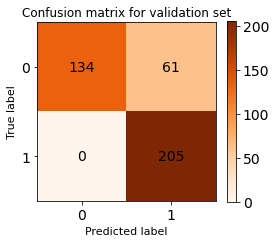

In [127]:
# Predicting the labels for the validation set
y_pred = best_model.predict(x_valid_red)
y_pred = (y_pred > 0.5).astype(int)

# Computing the confusion matrix
cm = sklearn.metrics.confusion_matrix(y_valid_red, y_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
plt.title('Confusion matrix for validation set', fontsize=12)
plt.xlabel('Predicted label', fontsize=11)
plt.ylabel('True label', fontsize=11)
plt.imshow(cm, cmap='Oranges', interpolation='nearest')
plt.colorbar(shrink=0.83)
plt.xticks([0,1], ['0', '1'])
plt.yticks([0,1], ['0', '1'])

# Adding the number of predictions to each cell
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(cm[i,j]), ha='center', va='center', color='black')

plt.show()

# Increased data


We now increase the number of samples in the original dataset by generating data with the nonlinear function `f(x, c=1)` below. The new number of samples is `N=8000`.

The reason for doing this is to see if the accuracy increases by much compared to that for the model trained on the original dataset. If it turns out to be so, it means that the original dataset was too small to get good results.

In [84]:
# Nonlinear function of a 2d array x
def f(x, c=1):
    r=0
    if c==1:
        if x[0]>-25 and x[1]>-35 and x[0]+x[1] < 30:
            r=1
        if x[0]+x[1] > 50:
            r=1
    if c==2:
        if (np.sign(x[0]-0.2*x[1]))*np.cos(np.linalg.norm(x)/(1.5*np.pi))>0:
            r=1
    return r


def filename(s, TYPE=1):
    return "./DATA/"+s+"-for-DNN-"+str(TYPE)+".dat"

In [85]:
# Parameters for the new data

# Number of data
N=8000

# Size of each sample
L=2

# Box size
B=100

#!mkdir DATA

2 5 1
./DATA/data_new-for-DNN-1.dat
./DATA/labels_new-for-DNN-1.dat


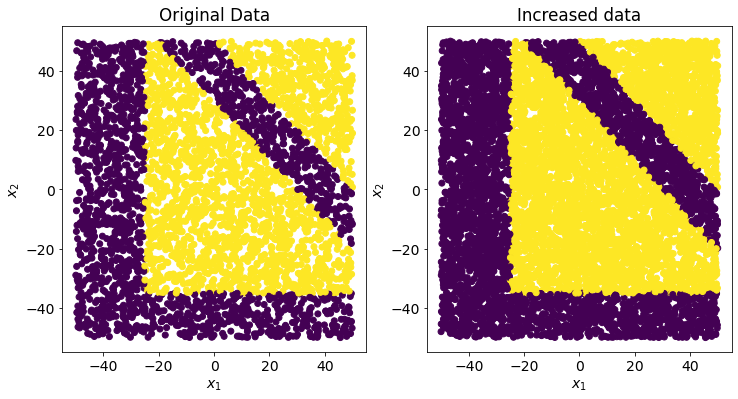

In [86]:
from matplotlib import cm

TYPE=1

# Random seed for reproducibility
np.random.seed(12345)
print(np.random.randint(0,10), np.random.randint(0,10), np.random.randint(0,10))

x_increased, y_increased = (np.random.random((N,2))-0.5)*B, np.zeros(N)
for i in range(N):
    # label data according to a nonlinear function "f"
    y_increased[i] = f(x_increased[i], TYPE)
        
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(x[:, 0], x[:, 1], c=y)
axs[0].set_title('Original Data')
axs[1].scatter(x_increased[:,0], x_increased[:,1], c=y_increased)        
axs[1].set_title('Increased data')

axs[0].set_xlabel('$x_1$')
axs[0].set_ylabel('$x_2$')
axs[1].set_xlabel('$x_1$')
axs[1].set_ylabel('$x_2$')

plt.show

fn = filename("data_new", TYPE)
np.savetxt(fn, x_increased)
print(fn)
fn = filename("labels_new", TYPE)
np.savetxt(fn, y_increased, fmt="%d")
print(fn)

In [88]:
x = np.loadtxt('./DATA/data_new-for-DNN-1.dat')
y = np.loadtxt('./DATA/labels_new-for-DNN-1.dat')

In [89]:
Per_train = 0.8
N = len(x)
L = len(x[0])
N_train = int(Per_train*N)
print("Number of samples in the increased dataset:", N)
print("Number of samples in the train increased dataset:", N_train)

Number of samples in the increased dataset: 8000
Number of samples in the train increased dataset: 6400


In [90]:
# Defining the trainig and validations sets
(x_train_incr, y_train_incr) = (x[0:N_train], y[0:N_train])
(x_valid_incr, y_valid_incr) = (x[N_train:], y[N_train:])
print("Train:", len(x_train_incr), "\t Validation:", len(x_valid_incr))

Train: 6400 	 Validation: 1600


In [91]:
# Rescaling the dataset
def Rescaling(x):
    X = (x-x.mean())/x.std()
    return X

x_train_incr = Rescaling(x_train_incr)
x_valid_incr = Rescaling(x_valid_incr)

print("Number of samples in the increased set:", len(x_train_incr))

Number of samples in the increased set: 6400


In [92]:
# Creating and training our NN model w/ the increased dataset
epochs = 450

best_model = Sequential() 

activation = best_activation
best_model.add(Dense(L, input_shape=(L,), activation=activation))
best_model.add(Dense(20, activation=activation))  
best_model.add(Dense(20, activation=activation))

dropout_rate = best_dropout_rate
best_model.add(Dropout(dropout_rate))
best_model.add(Dense(1, activation='sigmoid'))

optimizer = best_optimizer

best_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

batch_size = best_batch_size

# Fitting with increased data
fit_incr = best_model.fit(x_train_incr, y_train_incr, epochs=epochs, batch_size=batch_size, validation_data=(x_valid_incr, y_valid_incr), verbose=False)

The best valadation accuracy is 0.887.
The accuracy difference between original and increased datasets is 0.098.


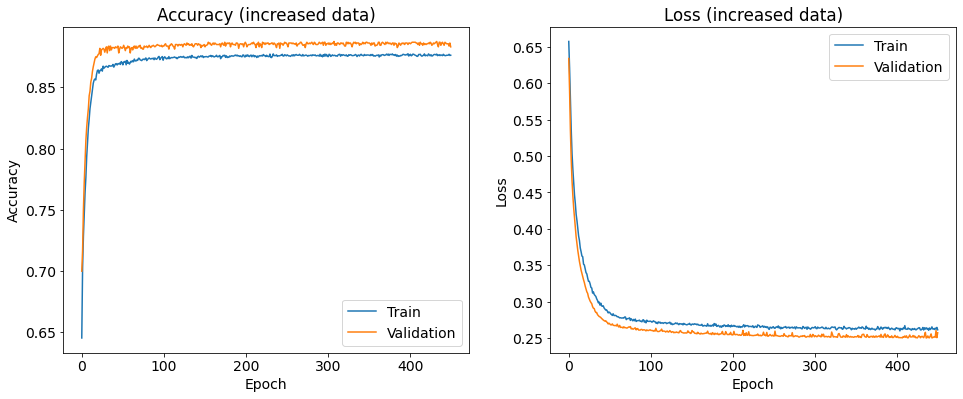

In [93]:
# Printing the max validation accurancy for the increased dataset and
# the difference w/ the one of original dataset
max_val_acc_incr = np.max(fit_incr.history['val_accuracy'])
print('The best valadation accuracy is %.3f.' %(max_val_acc_incr))
print('The accuracy difference between original and increased datasets is %.3f.' %((max_val_acc-max_val_acc_incr)))

# Creating the plots
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# accuracy in training and validation
ax1.plot(fit_incr.history['accuracy'])
ax1.plot(fit_incr.history['val_accuracy'])
ax1.set_title('Accuracy (increased data)')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'])

# loss in training and validation
ax2.plot(fit_incr.history['loss'])
ax2.plot(fit_incr.history['val_loss'])
ax2.set_title('Loss (increased data)')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'])

plt.show()

The max accuracy reached by the model w/ the increased dataset is slightly lower (9.8%) than the one achieved w/ the original dataset (88.7% vs 94.1%). 
The difference between the two values is little, thus we can infer that the original dataset contains the correct number of samples to precisely train our NN model.

The best valadation accuracy, 0.887, was achieved on the 307th epoch.


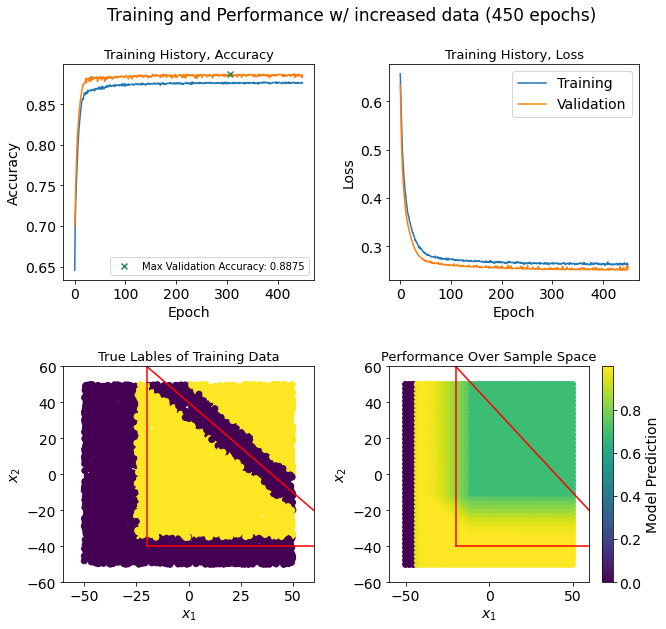

In [94]:
# Defining a grid to represent the sample space
dX = 2 #number of dimensions of the data
LG = int(np.sqrt(4000/2))
x1 = np.linspace(-50, 50, LG)
x2 = np.linspace(-50, 50, LG)
grid = np.zeros((LG*LG, 2))
k = 0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(x1[j], x2[i])
        k = k+1
        
# Rescaling grid points
grid_r = grid/50

# Performing a prediction on grid points
pred = best_model.predict(grid_r)


plt.rcParams['font.size'] = 14
max_val_acc_incr = np.max(fit_incr.history['val_accuracy'])
max_val_epoch_incr = np.argmax(fit_incr.history['val_accuracy'])
print('The best valadation accuracy, %.3f, was achieved on the %uth epoch.' %(max_val_acc_incr, max_val_epoch_incr))

#plot perfomance vs epochs
fig, AX = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle('Training and Performance w/ increased data (450 epochs)', y=1, fontsize=17)

# Training History, Accuracy
ax=AX[0][0]
ax.set_title('Training History, Accuracy', fontsize=13)
mystring = "Max Validation Accuracy: "+str(round(max_val_acc_incr, 4))
ax.scatter(max_val_epoch_incr, max_val_acc_incr, color='seagreen', marker='x', label=mystring, zorder = 10)
ax.plot(fit_incr.history['accuracy'])
ax.plot(fit_incr.history['val_accuracy'])
ax.legend(fontsize=10)
ax.set_xlabel('Epoch')
ax.set_ylabel("Accuracy")

# Training History, Loss
ax=AX[0][1]
ax.set_title('Training History, Loss', fontsize=13)
ax.plot(fit_incr.history['loss'], label="Training")
ax.plot(fit_incr.history['val_loss'], label="Validation")
ax.set_xlabel('Epoch')
ax.set_ylabel("Loss")
ax.legend()

def boundaries():    
    ax.plot((-20, -20), (-40, 60), c="r")
    ax.plot((-20, 80), (-40, -40), c="r")
    ax.plot((-20, 80), (60, -40), c="r")
    
# True Lables of Training Data
ax = AX[1][0]
ax.scatter(x[:,0], x[:,1], c=y)
ax.set_title('True Lables of Training Data', fontsize=13)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

boundaries()

# Performance Over Sample Space
ax=AX[1][1]
col = ax.scatter(grid[:,0], grid[:,1], c=pred)
ax.set_title('Performance Over Sample Space', fontsize=13)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.colorbar(col, label='Model Prediction')

boundaries()

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=0.90, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()

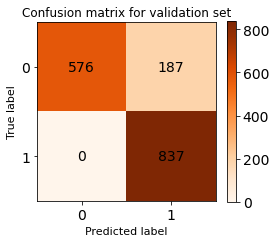

In [95]:
# Predicting the labels for the validation set
y_pred = best_model.predict(x_valid_incr)
y_pred = (y_pred > 0.5).astype(int)

# Computing the confusion matrix
cm = sklearn.metrics.confusion_matrix(y_valid_incr, y_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
plt.title('Confusion matrix for validation set', fontsize=12)
plt.xlabel('Predicted label', fontsize=11)
plt.ylabel('True label', fontsize=11)
plt.imshow(cm, cmap='Oranges', interpolation='nearest')
plt.colorbar(shrink=0.83)
plt.xticks([0,1], ['0', '1'])
plt.yticks([0,1], ['0', '1'])

# Adding the number of predictions to each cell
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(cm[i,j]), ha='center', va='center', color='black')

plt.show()

# Augmented data

The code "augments" the data by generating synthetic samples that are slightly shifted from the original ones. This can help increasing the diversity and size of the dataset and prevent overfitting of the DNN model.

It loops over each sample in x=($x_1$, $x_2$) (assuming they have the same length N) and generates N_augment copies of each sample by adding a random shift drawn from a normal distribution with mean 0 and standard deviation 0.05. The shift is applied to just the training sample `x_train`. 
The "noise" is not added to the validation sample `x_valid` beacuse ... `## ADD EXPLANATION`

One possible reason for doing this is to improve the generalization ability of the DNN model by exposing it to more variations of the data.

In [128]:
# Load the original dataset
x = np.loadtxt('../Exercises/E1/DATA/data-for-DNN-1.dat')
y = np.loadtxt('../Exercises/E1/DATA/labels-for-DNN-1.dat')

In [129]:
Per_train = 0.8
N = len(x)
L = len(x[0])
N_train = int(Per_train*N)
print("Number of samples in the augmented dataset:", N)
print("Number of samples in the train augmented dataset:", N_train)

Number of samples in the augmented dataset: 4000
Number of samples in the train augmented dataset: 3200


In [130]:
# Defining the trainig and validations sets
(x_train_aug, y_train_aug) = (x[0:N_train], y[0:N_train])
(x_valid_aug, y_valid_aug) = (x[N_train:], y[N_train:])

print("Train:", len(x_train_aug), "\t Validation:", len(x_valid_aug))

Train: 3200 	 Validation: 800


In [131]:
# Generating Gaussian noise
x_s = np.random.normal(loc=0.0, scale=0.05, size=x_train_aug.shape[:2])
y_s = np.random.normal(loc=0.0, scale=0.05, size=y_train_aug.shape[:1])

# "Augmenting" the training samples by addig Gaussian noise
x_train_aug = (x_train_aug + x_s ) 
#x_train_augmented1 = np.concatenate((x, x_train_augmented1), axis=0)
#y_train_aug = (y_train_aug + y_s )  
#y_train_augmented1 = np.concatenate((y, y_train_augmented1), axis=0)

print("Number of samples in original ", len(x_train_aug))
print("Number of samples in augmented  set:", len(x_train_aug))

Number of samples in original  3200
Number of samples in augmented  set: 3200


In [132]:
def Rescaling(x):
    X = (x-x.mean())/x.std()
    return X

x_train_aug = Rescaling(x_train_aug)
x_valid_aug = Rescaling(x_valid_aug) # we do not add noise to the validation set

print("Number of samples in augmented  set:", len(x_train_aug))

Number of samples in augmented  set: 3200


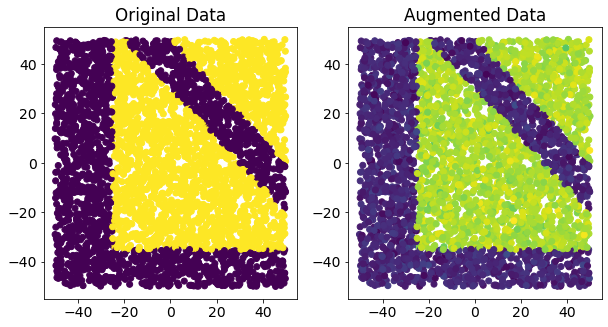

In [134]:
# Generating and adding noise to all the dataset just for the purpose of the plot
x_s_1 = np.random.normal(loc=0.0, scale=0.05, size=x.shape[:1])
x_s_2 = np.random.normal(loc=0.0, scale=0.05, size=x.shape[:1])
y_s_1 = np.random.normal(loc=0.0, scale=0.05, size=x.shape[:1])

# Plot the original data and the augmented data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(x[:, 0], x[:, 1], c=y)
axs[0].set_title('Original Data')
axs[1].scatter(x[:, 0]+x_s_1, x[:, 1]+x_s_2, c=y+y_s_1)
axs[1].set_title('Augmented Data')
plt.show()

The slight change in color in the "Augmented Data" plot is due to the adding of Gaussian noise to the label samples.

In [135]:
epochs = 450

best_model = Sequential() 

activation = best_activation
best_model.add(Dense(L, input_shape=(L,), activation=activation))
best_model.add(Dense(20, activation=activation))  
best_model.add(Dense(20, activation=activation))

dropout_rate = best_dropout_rate
best_model.add(Dropout(dropout_rate))
best_model.add(Dense(1, activation='sigmoid'))

optimizer = best_optimizer

best_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

batch_size = best_batch_size

#Fitting again with more data
fit_aug = best_model.fit(x_train_aug, y_train_aug, epochs=epochs, batch_size=batch_size, validation_data=(x_valid_aug, y_valid_aug), verbose=False)

The best valadation accuracy is 0.911.
The accuracy difference between original and augmented datasets is 0.074.


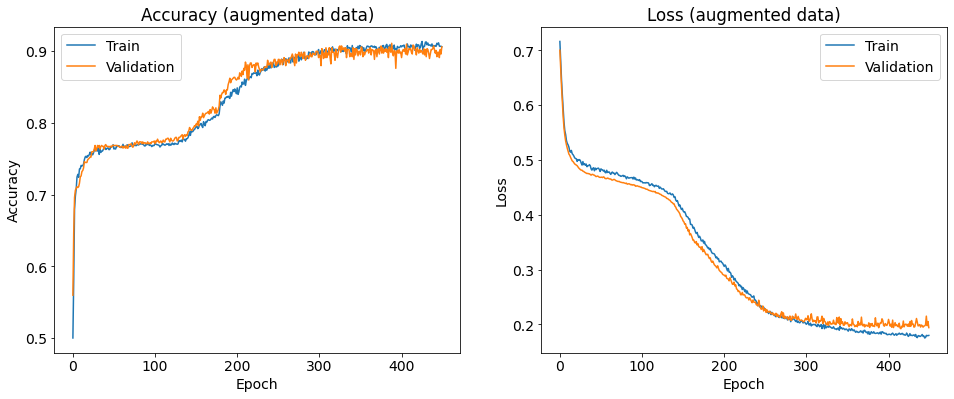

In [136]:
# Printing the max validation accurancy for the increased dataset and
# the difference w/ the one of original dataset
max_val_acc_aug = np.max(fit_aug.history['val_accuracy'])
print('The best valadation accuracy is %.3f.' %(max_val_acc_aug))
print('The accuracy difference between original and augmented datasets is %.3f.' %((max_val_acc-max_val_acc_aug)))

# Creating the plots
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Accuracy in training and validation
ax1.plot(fit_aug.history['accuracy'])
ax1.plot(fit_aug.history['val_accuracy'])
ax1.set_title('Accuracy (augmented data)')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'])

# Loss in training and validation
ax2.plot(fit_aug.history['loss'])
ax2.plot(fit_aug.history['val_loss'])
ax2.set_title('Loss (augmented data)')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'])

plt.show()

The best valadation accuracy, 0.911, was achieved on the 388th epoch.


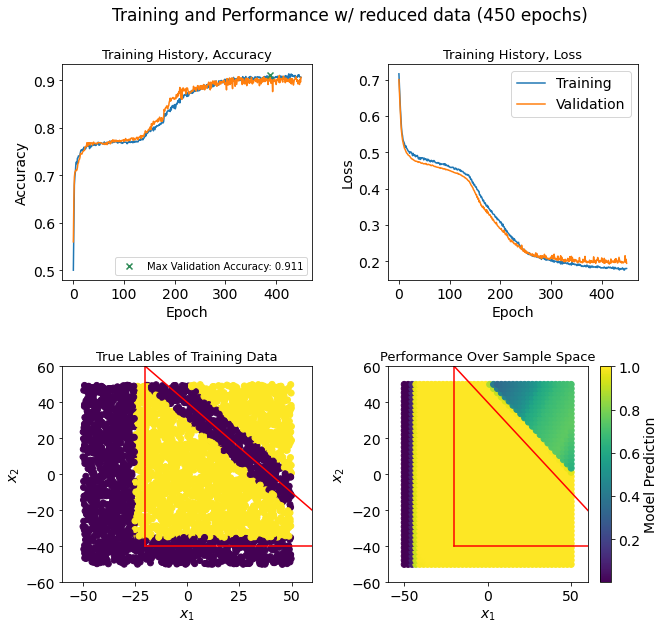

In [137]:
# Defining a grid to represent the sample space
dX = 2 #number of dimensions of the data
LG = int(np.sqrt(4000/2))
x1 = np.linspace(-50, 50, LG)
x2 = np.linspace(-50, 50, LG)
grid = np.zeros((LG*LG, 2))
k = 0
for i in range(LG):
    for j in range(LG):
        grid[k,:] = (x1[j], x2[i])
        k = k+1

# Rescaling grid points
grid_r = grid/50

# Performing a prediction on grid points
pred = best_model.predict(grid_r)


plt.rcParams['font.size'] = 14
max_val_acc_aug = np.max(fit_aug.history['val_accuracy'])
max_val_epoch_aug = np.argmax(fit_aug.history['val_accuracy'])
print('The best valadation accuracy, %.3f, was achieved on the %uth epoch.' %(max_val_acc_aug, max_val_epoch_aug))

# Plot perfomance vs epochs
fig, AX = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Training and Performance w/ reduced data (450 epochs)', y=1, fontsize=17)

# Training History, Accuracy
ax = AX[0][0]
ax.set_title('Training History, Accuracy', fontsize=13)
mystring = "Max Validation Accuracy: "+str(round(max_val_acc_aug, 3))
ax.scatter(max_val_epoch_aug, max_val_acc_aug, color='seagreen', marker='x', label=mystring, zorder = 10)
ax.plot(fit_aug.history['accuracy'])
ax.plot(fit_aug.history['val_accuracy'])
ax.legend(fontsize = 10)
ax.set_xlabel('Epoch')
ax.set_ylabel("Accuracy")

# Training History, Loss
ax=AX[0][1]
ax.set_title('Training History, Loss', fontsize=13)
ax.plot(fit_aug.history['loss'], label="Training")
ax.plot(fit_aug.history['val_loss'], label="Validation")
ax.set_xlabel('Epoch')
ax.set_ylabel("Loss")
ax.legend()

def boundaries():    
    ax.plot((-20,-20), (-40,60), c="r")
    ax.plot((-20,80), (-40,-40), c="r")
    ax.plot((-20,80), (60,-40), c="r")

# True Lables of Training Data
ax=AX[1][0]
ax.scatter(x[:,0], x[:,1], c=y)
ax.set_title('True Lables of Training Data', fontsize=13)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

boundaries()

# Performance Over Sample Space
ax=AX[1][1]
col = ax.scatter(grid[:,0], grid[:,1], c=pred)
ax.set_title('Performance Over Sample Space', fontsize=13)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.colorbar(col, label ='Model Prediction')

boundaries()

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=0.90, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()

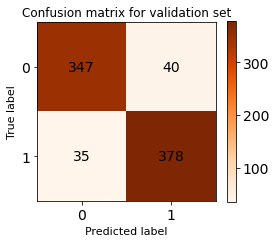

In [138]:
# Predicting the labels for the validation set
y_pred = best_model.predict(x_valid_aug)
y_pred = (y_pred > 0.5).astype(int)

# Computing the confusion matrix
cm = sklearn.metrics.confusion_matrix(y_valid_aug, y_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
plt.title('Confusion matrix for validation set', fontsize=12)
plt.xlabel('Predicted label', fontsize=11)
plt.ylabel('True label', fontsize=11)
plt.imshow(cm, cmap='Oranges', interpolation='nearest')
plt.colorbar(shrink=0.83)
plt.xticks([0,1], ['0', '1'])
plt.yticks([0,1], ['0', '1'])

# Adding the number of predictions to each cell
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(cm[i,j]), ha='center', va='center', color='black')

plt.show()

## Task number 3 

We generated data from a nonlinear function returning a butterfly shape.

In [139]:
x_shape = np.loadtxt('./DATA/data-for-butterfly-DNN-1.dat')
y_shape = np.loadtxt('./DATA/labels-for-butterfly-DNN-1.dat')

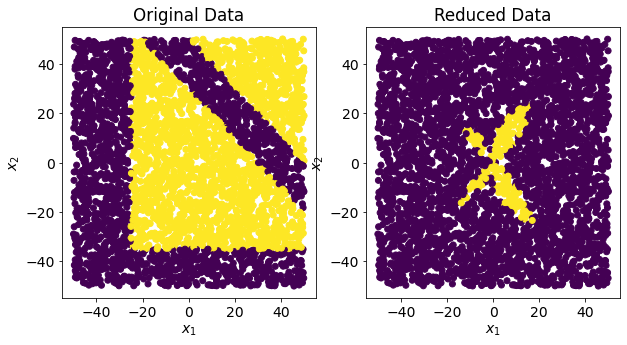

In [140]:
# Plot the original data and the reduced data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(x[:, 0], x[:, 1], c=y)
axs[0].set_title('Original Data')
axs[1].scatter(x_shape[:, 0], x_shape[:, 1], c=y_shape)
axs[1].set_title('Reduced Data')

axs[0].set_xlabel('$x_1$')
axs[0].set_ylabel('$x_2$')
axs[1].set_xlabel('$x_1$')
axs[1].set_ylabel('$x_2$')

plt.show()

In [143]:
Per_train = 0.8
N = len(x)
L = len(x[0])
N_train = int(Per_train*N)
print("Number of samples in the butterfly dataset:", N)
print("Number of samples in the train butterfly dataset:", N_train)

Number of samples in the butterfly dataset: 4000
Number of samples in the train butterfly dataset: 3200


In [144]:
# Defining the trainig and validations sets
(x_train_shape, y_train_shape) = (x_shape[0:N_train], y_shape[0:N_train])
(x_valid_shape, y_valid_shape) = (x_shape[N_train:], y_shape[N_train:])
print("Train:", len(x_train_shape), "\t Validation:", len(x_valid_shape))

Train: 3200 	 Validation: 800


In [145]:
# Creating and training our NN model w/ the increased dataset
epochs = 450

best_model = Sequential() 

activation = best_activation
best_model.add(Dense(L, input_shape=(L,), activation=activation))
best_model.add(Dense(20, activation=activation))  
best_model.add(Dense(20, activation=activation))

dropout_rate = best_dropout_rate
best_model.add(Dropout(dropout_rate))
best_model.add(Dense(1, activation='sigmoid'))

optimizer = best_optimizer

best_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

batch_size = best_batch_size

# Fitting with increased data
fit_shape = best_model.fit(x_train_shape, y_train_shape, epochs=epochs, batch_size=batch_size, validation_data=(x_valid_shape, y_valid_shape), verbose=False)

The best valadation accuracy is 0.955.
The accuracy difference between original and butterfly datasets is 0.030.


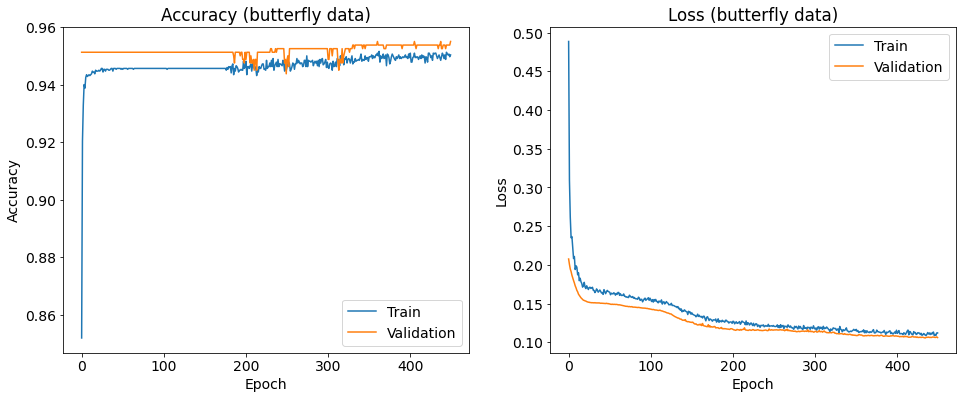

In [147]:
# Printing the max validation accurancy for the increased dataset and
# the difference w/ the one of original dataset
max_val_acc_shape = np.max(fit_shape.history['val_accuracy'])
print('The best valadation accuracy is %.3f.' %(max_val_acc_shape))
print('The accuracy difference between original and butterfly datasets is %.3f.' %((max_val_acc-max_val_acc_shape)))

# Creating the plots
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Accuracy in training and validation
ax1.plot(fit_shape.history['accuracy'])
ax1.plot(fit_shape.history['val_accuracy'])
ax1.set_title('Accuracy (butterfly data)')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'])

# Loss in training and validation
ax2.plot(fit_shape.history['loss'])
ax2.plot(fit_shape.history['val_loss'])
ax2.set_title('Loss (butterfly data)')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'])

plt.show()

Our model achieved a pretty high accuracy value on the test data. This is a good result considering that we used a linear model to fit a nonlinear function. Moreover, our model was robust to noise and data augmentation, as it performed equally well on another dataset that had different shifts and scales. This shows that our model can generalize well unseen data too and handle some degree of variation and uncertainty.

The best valadation accuracy, 0.955, was achieved on the 360th epoch.


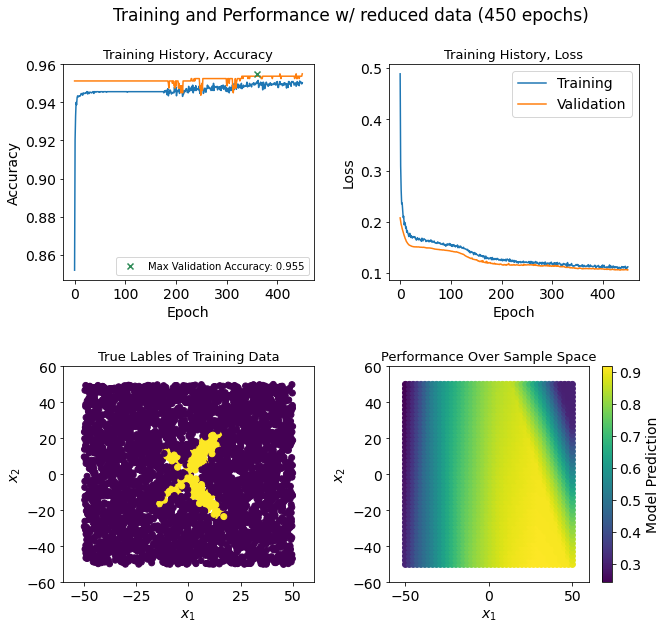

In [152]:
# Defining a grid to represent the sample space
dX = 2 #number of dimensions of the data
LG = int(np.sqrt(4000/2))
x1 = np.linspace(-50, 50, LG)
x2 = np.linspace(-50, 50, LG)
grid = np.zeros((LG*LG, 2))
k = 0
for i in range(LG):
    for j in range(LG):
        grid[k,:] = (x1[j], x2[i])
        k = k+1

# Rescaling grid points
grid_r = grid/50

# Performing a prediction on grid points
pred = best_model.predict(grid_r)


plt.rcParams['font.size'] = 14
max_val_acc_shape = np.max(fit_shape.history['val_accuracy'])
max_val_epoch_shape = np.argmax(fit_shape.history['val_accuracy'])
print('The best valadation accuracy, %.3f, was achieved on the %uth epoch.' %(max_val_acc_shape, max_val_epoch_shape))

# Plot perfomance vs epochs
fig, AX = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Training and Performance w/ reduced data (450 epochs)', y=1, fontsize=17)

# Training History, Accuracy
ax = AX[0][0]
ax.set_title('Training History, Accuracy', fontsize=13)
mystring = "Max Validation Accuracy: "+str(round(max_val_acc_shape, 3))
ax.scatter(max_val_epoch_shape, max_val_acc_shape, color='seagreen', marker='x', label=mystring, zorder = 10)
ax.plot(fit_shape.history['accuracy'])
ax.plot(fit_shape.history['val_accuracy'])
ax.legend(fontsize = 10)
ax.set_xlabel('Epoch')
ax.set_ylabel("Accuracy")

# Training History, Loss
ax=AX[0][1]
ax.set_title('Training History, Loss', fontsize=13)
ax.plot(fit_shape.history['loss'], label="Training")
ax.plot(fit_shape.history['val_loss'], label="Validation")
ax.set_xlabel('Epoch')
ax.set_ylabel("Loss")
ax.legend()

#def boundaries():    
#    ax.plot((-20,-20), (-40,60), c="r")
#    ax.plot((-20,80), (-40,-40), c="r")
#    ax.plot((-20,80), (60,-40), c="r")

# True Lables of Training Data
ax=AX[1][0]
ax.scatter(x_shape[:,0], x_shape[:,1], c=y_shape)
ax.set_title('True Lables of Training Data', fontsize=13)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

#boundaries()

# Performance Over Sample Space
ax=AX[1][1]
col = ax.scatter(grid[:,0], grid[:,1], c=pred)
ax.set_title('Performance Over Sample Space', fontsize=13)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.colorbar(col, label ='Model Prediction')

#boundaries()

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=0.90, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()

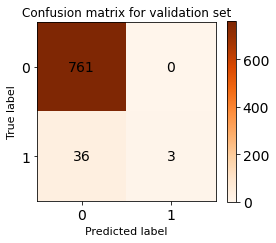

In [153]:
# Predicting the labels for the validation set
y_pred = best_model.predict(x_valid_shape)
y_pred = (y_pred > 0.5).astype(int)

# Computing the confusion matrix
cm = sklearn.metrics.confusion_matrix(y_valid_shape, y_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
plt.title('Confusion matrix for validation set', fontsize=12)
plt.xlabel('Predicted label', fontsize=11)
plt.ylabel('True label', fontsize=11)
plt.imshow(cm, cmap='Oranges', interpolation='nearest')
plt.colorbar(shrink=0.83)
plt.xticks([0,1], ['0', '1'])
plt.yticks([0,1], ['0', '1'])

# Adding the number of predictions to each cell
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(cm[i,j]), ha='center', va='center', color='black')

plt.show()